<a href="https://colab.research.google.com/github/SarangMohrir/CV/blob/main/fmnist_ann_dataset_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [30]:
torch.manual_seed(42)

In [31]:
df = pd.read_csv("/content/fashion-mnist_train.csv")

In [32]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [33]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


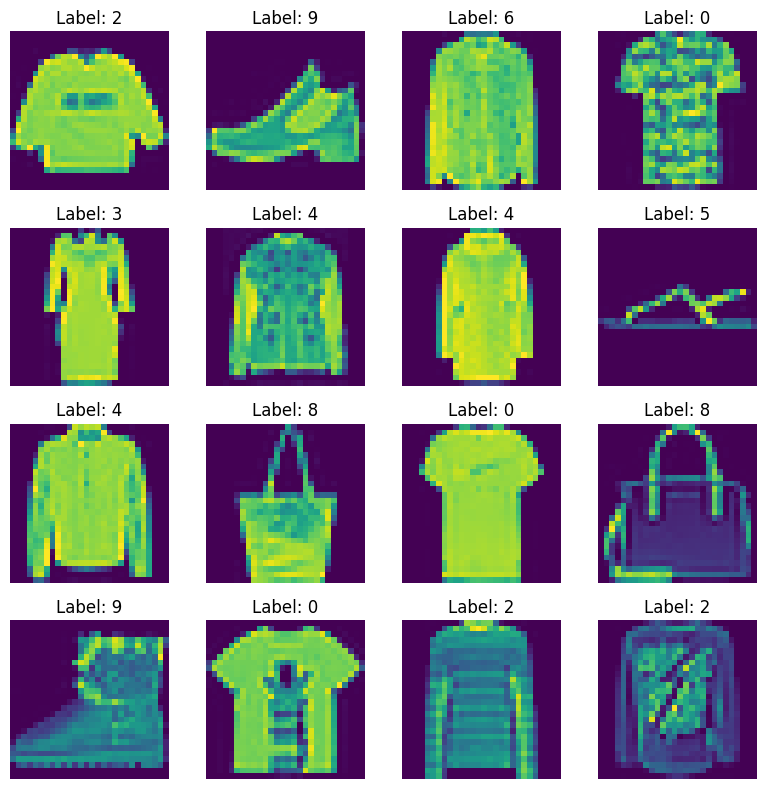

In [34]:
import matplotlib.pyplot as plt

# Get the first 16 rows (images) from the dataframe
grid_images = df.head(16)

# Create a figure and subplots for the grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.ravel() # Flatten the 2D array of axes

# Iterate through the rows and display each image in a subplot
for i, (index, row) in enumerate(grid_images.iterrows()):
    image_data = row[1:].values.astype('uint8')  # Exclude the 'label' column
    image = image_data.reshape(28, 28)

    axes[i].imshow(image, cmap='viridis') # Changed colormap to viridis
    axes[i].set_title(f'Label: {row.iloc[0]}') # Use .iloc for accessing the label by position
    axes[i].axis('off') # Hide axes

plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

In [35]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#while training neural network always have them in range of [0, 1]
X_train = x_train / 255.0
X_test = x_test / 255.0

In [38]:
class customDataset(Dataset):
  def __init__(self, features, labels) -> None:
     super().__init__()
     self.features = torch.tensor(features, dtype=torch.float32)
     self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]


In [39]:
trainDataset = customDataset(X_train, y_train)

In [40]:
trainDataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2275,
         0.5333, 0.0000, 0.0

In [41]:
testDataset = customDataset(X_test, y_test)

In [42]:
trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False)
#we do not shuffle in testLoader as we do not want data to be shuffled

In [43]:
class myNN(nn.Module):
  def __init__(self, num_features) -> None:
     super().__init__()
     self.model = nn.Sequential(
         nn.Linear(num_features, 128),
         nn.ReLU(),
         nn.Linear(128, 64),
         nn.ReLU(),
         nn.Linear(64, 10)
     )

  def forward(self, x):
    return self.model(x)

In [44]:
epochs = 100
learning_rate = 0.1
print(X_train.shape[1])

784


In [45]:
# instantiate the model
model = myNN(X_train.shape[1])
model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr= learning_rate)

In [46]:
len(trainLoader)

1500

In [47]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in trainLoader:

    # forward pass
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(trainLoader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6352872455318769
Epoch: 2 , Loss: 0.4304986933817466
Epoch: 3 , Loss: 0.38612620331346986
Epoch: 4 , Loss: 0.3584607186516126
Epoch: 5 , Loss: 0.3376494685560465
Epoch: 6 , Loss: 0.3227646785800656
Epoch: 7 , Loss: 0.30785389595727125
Epoch: 8 , Loss: 0.29498188248028356
Epoch: 9 , Loss: 0.2854692431092262
Epoch: 10 , Loss: 0.27467057487616936
Epoch: 11 , Loss: 0.26830568559716145
Epoch: 12 , Loss: 0.25814215187107525
Epoch: 13 , Loss: 0.24940819021190205
Epoch: 14 , Loss: 0.24444738084822892
Epoch: 15 , Loss: 0.23859191479658087
Epoch: 16 , Loss: 0.23155898495018482
Epoch: 17 , Loss: 0.22562562109405795
Epoch: 18 , Loss: 0.220296459933122
Epoch: 19 , Loss: 0.21206333881616593
Epoch: 20 , Loss: 0.20960091057543953
Epoch: 21 , Loss: 0.20624992236122489
Epoch: 22 , Loss: 0.19986102367161462
Epoch: 23 , Loss: 0.19530413204431535
Epoch: 24 , Loss: 0.19312162966746838
Epoch: 25 , Loss: 0.18764106344679993
Epoch: 26 , Loss: 0.1836644180783381
Epoch: 27 , Loss: 0.1801829884

In [48]:
model.eval()

myNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [50]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in testLoader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model(batch_features).to('cuda')
    _, predicted = torch.max(outputs.data, 1)
    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}')

Accuracy: 88.98333333333333


# Fashion MNIST Classification with PyTorch

This notebook demonstrates a simple image classification task using the Fashion MNIST dataset and a basic neural network implemented with PyTorch.

## Project Description

The goal of this project is to build and train a neural network to classify images of clothing items from the Fashion MNIST dataset. The dataset consists of 60,000 training images and 10,000 test images, each being a 28x28 grayscale image, associated with a label from 10 classes (e.g., T-shirt/top, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot).

The notebook covers the following steps:

1.  **Data Loading and Exploration**: Loading the Fashion MNIST dataset from a CSV file and visualizing some sample images.
2.  **Data Preprocessing**: Splitting the data into training and testing sets and normalizing the pixel values.
3.  **Custom Dataset and DataLoader**: Creating a custom PyTorch Dataset and DataLoader for efficient data handling during training.
4.  **Model Definition**: Defining a simple feedforward neural network using PyTorch's `nn.Module`.
5.  **Training**: Training the neural network using stochastic gradient descent and Cross-Entropy Loss.
6.  **Evaluation**: Evaluating the trained model's accuracy on the test set.

## Setup and Requirements

To run this notebook, you will need to have the following libraries installed:

-   pandas
-   numpy
-   scikit-learn
-   torch
-   matplotlib

You can install these libraries using pip: